In [1]:
# import kagglehub

In [2]:
# path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

# print("Path to dataset files:", path)

In [3]:
# import shutil
# shutil.move(path, "./Data/BRATS")

In [4]:
from utils.train import warnings, set_seeds
from Network.Unet import Custom3DUnet
import torch
from utils.CustomDataset import BRATS
from torch.utils.data import random_split, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from skimage import measure
from matplotlib.patches import Polygon
import SimpleITK as sitk
import numpy as np
import random
def seeding(num):
    torch.manual_seed(num)
    torch.cuda.manual_seed(num)
    torch.cuda.manual_seed_all(num)
    np.random.seed(num)
    random.seed(num)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True

seeding(2025)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skip = False
index=0
depth=37

/home/taehwan/MICCAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
diceLoss = smp.losses.DiceLoss(
   mode="multiclass",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability
   ignore_index=None,          # Don't ignore any classes
   eps=1e-7                    # Epsilon for numerical stability
)
class Hausdolf95(torch.nn.Module):
    def __init__(self):
        super(Hausdolf95, self).__init__()
        self.distancef = torch.nn.PairwiseDistance()
    def distance(self, x, y):
        return self.distancef(x, y)
        
    def forward(self, x, y):
        maximum_d=torch.max(self.distance(x, y))
        return maximum_d
hausdolf95 = Hausdolf95()
jaccardf = smp.losses.JaccardLoss(
   mode="multiclass",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability          
   eps=1e-7
)

In [6]:
def evaluation(net, loader, diceLoss, HF95, jaccard,DEVICE):
    net.eval()
    net.to(DEVICE)
    dicef= diceLoss.to(DEVICE)
    hf95f = HF95.to(DEVICE)
    jaccardf = jaccard.to(DEVICE)
    dice = 0
    hf95 = 0
    jacc = 0
    length = len(loader)
    for sample in loader:
        X= torch.stack([s["x"] for s in sample], 0)
        Y= torch.stack([s["y"] for s in sample], 0)
        out = net(X.type(torch.float32).unsqueeze(0).to(DEVICE)) 
        dice += (1-dicef(out.type(torch.float32).to(DEVICE), Y.type(torch.int64).to(DEVICE))).item()
        jacc += (1-jaccardf(out.type(torch.float32).to(DEVICE), Y.type(torch.int64).to(DEVICE))).item()
        hf95 += hf95f(out.squeeze().type(torch.float32).to(DEVICE), torch.nn.functional.one_hot(Y.type(torch.int64).squeeze(), 4).permute(3, 0, 1, 2).type(torch.float32).to(DEVICE)).item()
    return {"dice": dice/length, "hf95":hf95/length, 'jaccard': jacc/length}
def convert_to_one_hot(label, classes = 4):
    return torch.nn.functional.one_hot(torch.Tensor(label).type(torch.int64), classes).detach().numpy()
def display(orient, label, num_classes=4):

    fig, ax=plt.subplots(1, 2)

    # ax[0].imshow(label)
    ax[0].imshow(orient, cmap="gray")
    ax[1].imshow(orient, 'gray')
    for indx in range(4):
        if indx == 0:
            continue
        countour = measure.find_contours(convert_to_one_hot(label, num_classes)[...,indx], 0.7)
        for legion in countour:
            
            y=legion.T[0].copy()
            x=legion.T[1].copy()
            legion[:,0]= x
            legion[:,1]= y
            poly=Polygon(legion, closed=False)
            if indx == 1:
                poly.set_color([0,1,1,0.3])
            if indx == 2:
                poly.set_color([1,0,0,0.3])
            if indx == 3:
                poly.set_color([1,0.95,0,0.3])
            ax[1].add_patch(poly)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    # ax[2].set_axis_off()
    fig.tight_layout()
    fig.show()
def visualization(net, BRATS, index, depth, DEVICE):
    net.to(DEVICE)
    net.eval()
    ori = sitk.GetImageFromArray(BRATS[index]['x'].detach().numpy()[depth, ...], False)
    lab = sitk.GetImageFromArray(BRATS[index]['y'].type(torch.int32).detach().numpy()[depth ,...], False)
    label = sitk.GetArrayFromImage(lab)
    orient = sitk.GetArrayFromImage(ori)
    out = net(BRATS[index]['x'].unsqueeze(0).unsqueeze(0).to(DEVICE))
    display(orient, label)
    display(orient, out.cpu().squeeze().argmax(0).detach().numpy()[depth])

def visualization2(net, fets2023, index, nslice,DEVICE):
    net.to(DEVICE)
    net.eval()
    ori = sitk.GetImageFromArray(fets2023[index]['x'].detach().numpy(), False)
    lab = sitk.GetImageFromArray(fets2023[index]['y'].type(torch.int32).detach().numpy(), False)
    label = sitk.GetArrayFromImage(lab)
    orient = sitk.GetArrayFromImage(ori)
    out = net(fets2023[index]['x'].unsqueeze(0).unsqueeze(0).to(DEVICE))
    display2(orient.squeeze(), label.squeeze())
    display2(orient.squeeze(), out.cpu().squeeze().argmax(0).detach().numpy())

def display2(orient, label, nslice=15, num_classes=4):
    depth = orient.shape[0]
    ranger = range(nslice, nslice*(depth//nslice), nslice)
    fig, ax=plt.subplots(1, len(ranger))
    fig.set_size_inches(16, 16)
    for axind,i in enumerate(range(nslice, nslice*(depth//nslice), nslice)):
        ax[axind].imshow(orient[i,...], cmap="gray")
    
        for indx in range(4):
            if indx == 0:
                continue
            countour = measure.find_contours(convert_to_one_hot(label[i,...], num_classes)[...,indx], 0.7)
            for legion in countour:
                
                y=legion.T[0].copy()
                x=legion.T[1].copy()
                legion[:,0]= x
                legion[:,1]= y
                poly=Polygon(legion, closed=False)
                if indx == 1:
                    poly.set_color([0,1,1,0.6])
                if indx == 2:
                    poly.set_color([1,0,0,0.6])
                if indx == 3:
                    poly.set_color([0.85,0.75,0,0.6])
                ax[axind].add_patch(poly)
        ax[axind].set_axis_off()
    fig.tight_layout()
    fig.show()

In [7]:
dataset = BRATS("Data/BRATS/3/BraTS2020_training_data/content/client/test")
evaloader = DataLoader(dataset, 1, shuffle=False, collate_fn=lambda x:x)
visualset = BRATS("Data/BRATS/3/BraTS2020_training_data/content/client/test")

/tmp/ipykernel_1061529/1661478949.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/CentralBRATS/net.pt"))


{'dice': 0.1756697836376372, 'hf95': 10.15085422425043, 'jaccard': 0.12824263033412753}


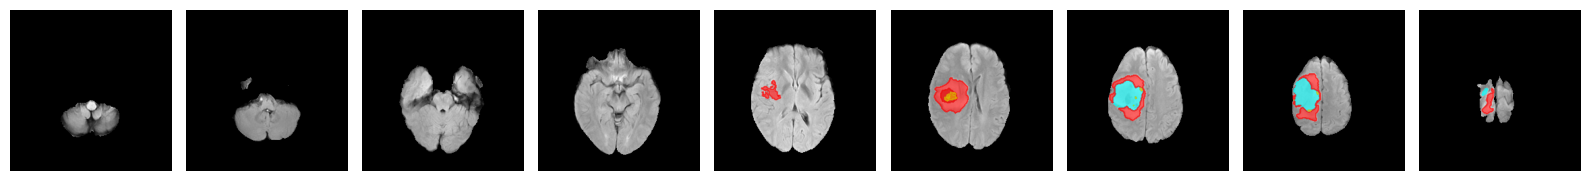

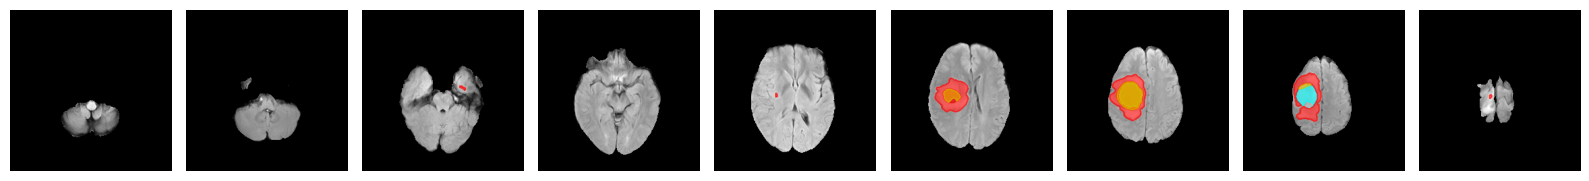

In [8]:
net = Custom3DUnet(1, 4, True, f_maps=4, layer_order="gcr", num_groups=4)
net.load_state_dict(torch.load("Models/CentralBRATS/net.pt",  weights_only=True))
net.to(DEVICE)
visualization2(net, visualset, index, 15, DEVICE)
if not skip:
    print(evaluation(net, evaloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1061529/3679274205.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedAvgBRATS/net.pt"))


{'dice': 0.1741337109179724, 'hf95': 6.796758231662569, 'jaccard': 0.1276464064915975}


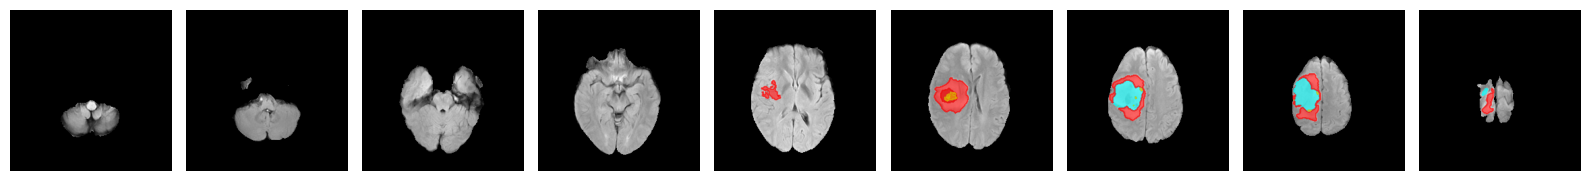

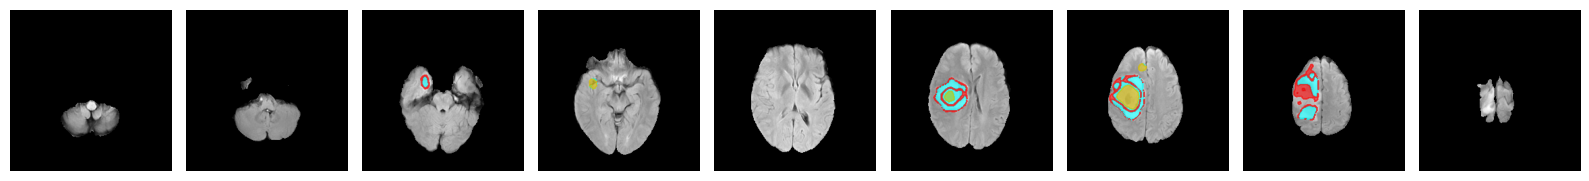

In [9]:
net.load_state_dict(torch.load("Models/FedAvgBRATS/net.pt",  weights_only=True))
visualization2(net, visualset, index, depth, DEVICE)
if not skip:
    print(evaluation(net, evaloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1061529/2614676356.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedPIDBRATS/net.pt"))


{'dice': 0.16934106747309366, 'hf95': 7.2665031750996905, 'jaccard': 0.12279732596306574}


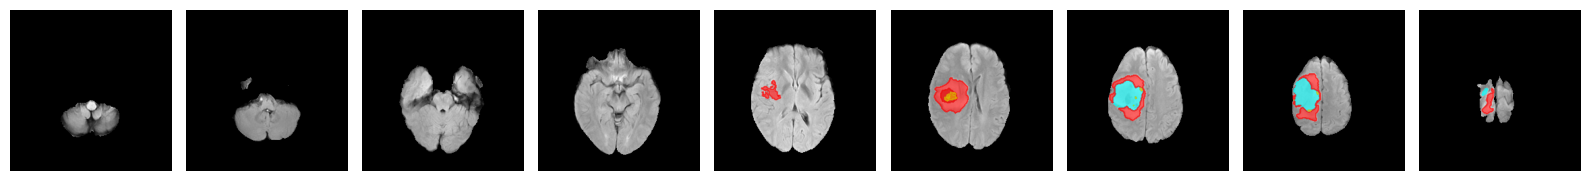

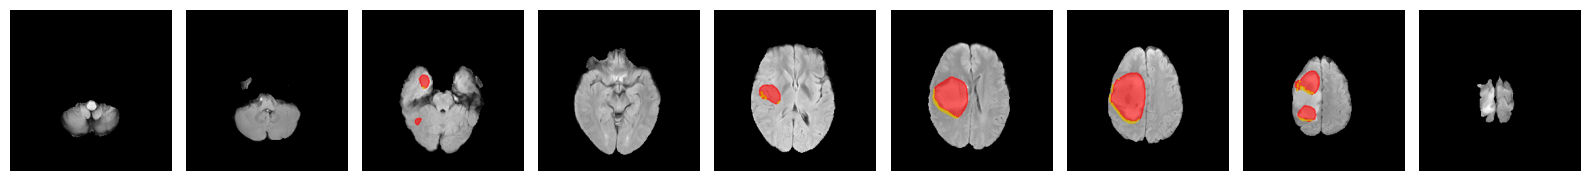

In [10]:
net.load_state_dict(torch.load("Models/FedPIDBRATS/net.pt", weights_only=True))
visualization2(net, visualset, index, depth, DEVICE)
if not skip:
    print(evaluation(net, evaloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1061529/2011676783.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedLWRBRATS/net.pt"))


{'dice': 0.17380911395663307, 'hf95': 6.6990942387353805, 'jaccard': 0.12743616104125977}


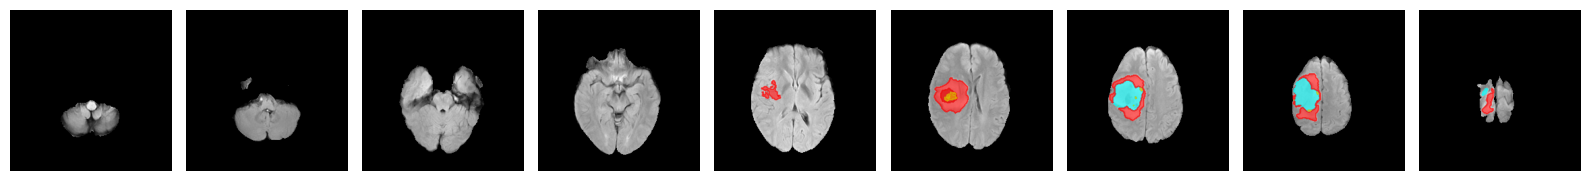

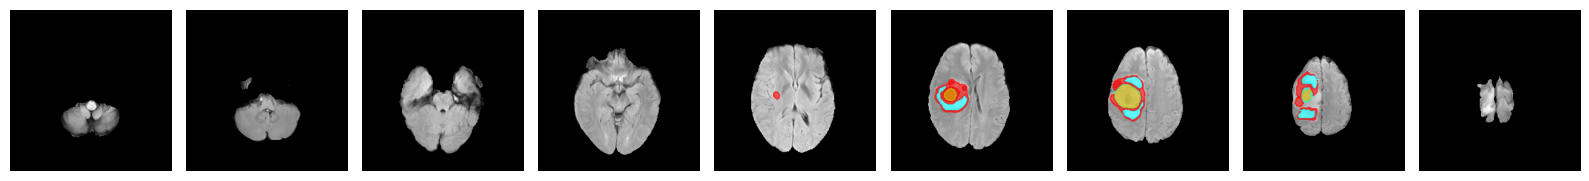

In [11]:
net.load_state_dict(torch.load("Models/FedLWRBRATS/net.pt", weights_only=True))
visualization2(net, visualset, index, depth, DEVICE)
if not skip:
    print(evaluation(net, evaloader, diceLoss, hausdolf95, jaccardf, DEVICE))

/tmp/ipykernel_1061529/1560989220.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("Models/FedRefBRATS/net.pt"))


{'dice': 0.17422843689010256, 'hf95': 6.810633557183402, 'jaccard': 0.1277130459036146}


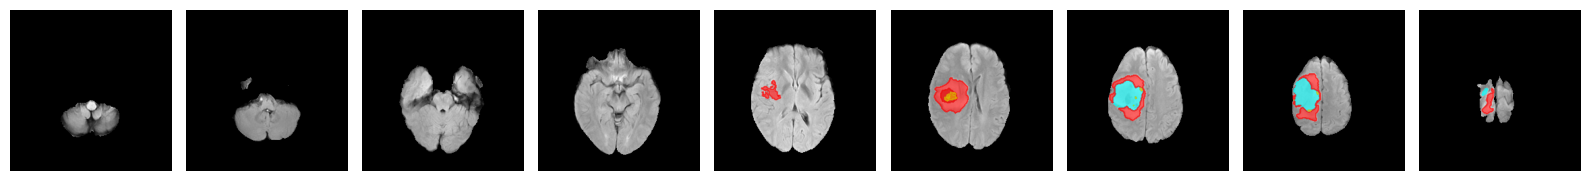

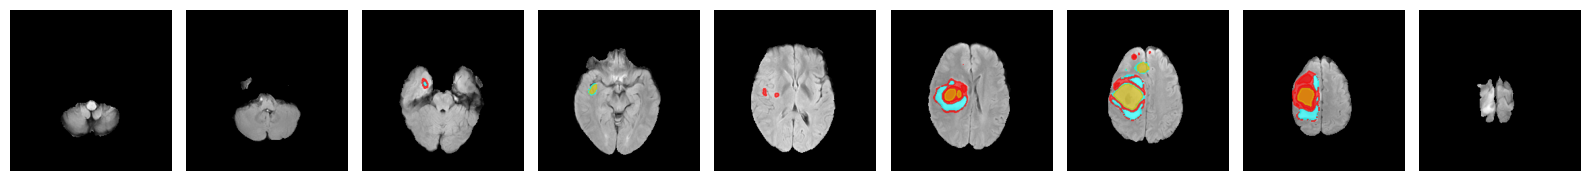

In [12]:
net.load_state_dict(torch.load("Models/FedRefBRATS/net.pt",  weights_only=True))
visualization2(net, visualset, index, depth, DEVICE)
if not skip:
    print(evaluation(net, evaloader, diceLoss, hausdolf95, jaccardf, DEVICE))

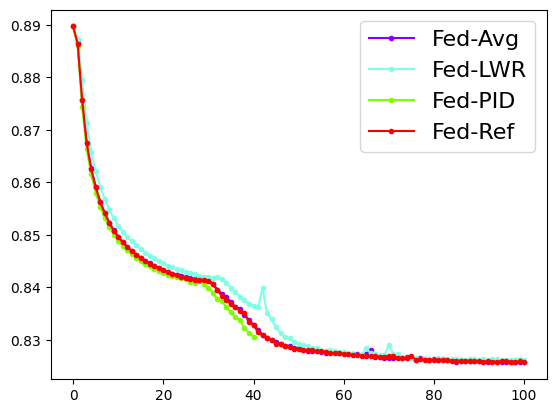

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
 
fedavgframe = pd.read_csv('Result/fedavg/FedAvg_brats.csv')
fedpidframe = pd.read_csv('Result/fedpid/FedPID_brats.csv')
fedlwrframe = pd.read_csv('Result/fedlwr/FedLWR_brats.csv')
fedrefframe = pd.read_csv("Result/fedref/FedRef_brats.csv")
plt.plot(fedavgframe['loss'].to_numpy(), color=(0.5,0,1), label= "Fed-Avg", marker= ".")
plt.plot(fedlwrframe['loss'].to_numpy(), color=(0.5,1,0.9), label= "Fed-LWR", marker= ".")
plt.plot(fedpidframe['loss'].to_numpy(), color=(0.5,1,0), label= "Fed-PID", marker= ".")
plt.plot(fedrefframe['loss'].to_numpy(), color=(1,0,0), label= "Fed-Ref", marker= ".")
plt.legend(fontsize=16)
# plt.xlabel("round")
# plt.ylabel("Loss")

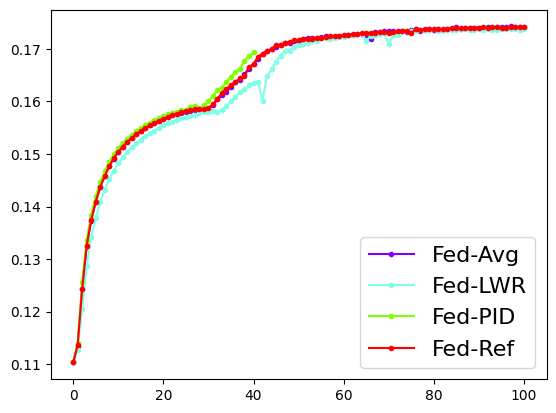

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
 
fedavgframe = pd.read_csv('Result/fedavg/FedAvg_brats.csv')
fedpidframe = pd.read_csv('Result/fedpid/FedPID_brats.csv')
fedlwrframe = pd.read_csv('Result/fedlwr/FedLWR_brats.csv')
fedrefframe = pd.read_csv("Result/fedref/FedRef_brats.csv")
plt.plot(fedavgframe['mDice'].to_numpy(), color=(0.5,0,1), label= "Fed-Avg", marker= ".")
plt.plot(fedlwrframe['mDice'].to_numpy(), color=(0.5,1,0.9), label= "Fed-LWR", marker= ".")
plt.plot(fedpidframe['mDice'].to_numpy(), color=(0.5,1,0), label= "Fed-PID", marker= ".")
plt.plot(fedrefframe['mDice'].to_numpy(), color=(1,0,0), label= "Fed-Ref", marker= ".")
plt.legend(fontsize=16)
# plt.xlabel("round")
# plt.ylabel("DiceScore")

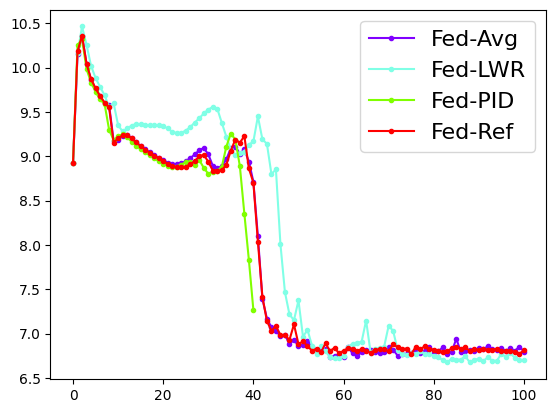

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
 
fedavgframe = pd.read_csv('Result/fedavg/FedAvg_brats.csv')
fedpidframe = pd.read_csv('Result/fedpid/FedPID_brats.csv')
fedlwrframe = pd.read_csv('Result/fedlwr/FedLWR_brats.csv')
fedrefframe = pd.read_csv("Result/fedref/FedRef_brats.csv")
plt.plot(fedavgframe['mHF95'].to_numpy(), color=(0.5,0,1), label= "Fed-Avg", marker= ".")
plt.plot(fedlwrframe['mHF95'].to_numpy(), color=(0.5,1,0.9), label= "Fed-LWR", marker= ".")
plt.plot(fedpidframe['mHF95'].to_numpy(), color=(0.5,1,0), label= "Fed-PID", marker= ".")
plt.plot(fedrefframe['mHF95'].to_numpy(), color=(1,0,0), label= "Fed-Ref", marker= ".")
plt.legend(fontsize=16)
# plt.xlabel("round")
# plt.ylabel("Housdolf Distance")